In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

# Data Preprocessing

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

# Autoencoder

In [6]:
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.538061797618866
Epoch [2/5], Loss: 0.5298854112625122
Epoch [3/5], Loss: 0.5318129062652588
Epoch [4/5], Loss: 0.5006384253501892
Epoch [5/5], Loss: 0.5331690311431885


In [7]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Experiment

In [9]:
# cluster: 6, CLient: 10

In [9]:
alpha_values = [0.1, 0.5, 1, 5, 10, 20]
num_clients = 10
num_clusters = 6
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [9]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [ ]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    # Classic
    partitioned_data_classic = partition.balanced_dirichlet_partition(
        trainingset, partitions_number=num_clients, alpha=alpha
    )

    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]


    local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []

    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model, train_loader, optimizer, log_interval, train_losses, train_counter)

    test_losses_classic_weak = []
    test(trial_model, test_loader, test_losses_classic_weak)

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if alpha not in results["classic"]:
            results["classic"][alpha] = {"losses": [], "accuracy": []}

        results["classic"][alpha]["losses"].extend(test_losses)
        results["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_clusters]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if alpha not in clusteredResults["classic"]:
            clusteredResults["classic"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][alpha]["losses"].extend(test_losses)
        clusteredResults["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373595


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.305434
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.275401
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.236221
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.229350
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.255284
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.156510
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.163547
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.094289
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.931286
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.849544
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.680981
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.765529
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.637998
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.575528
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.372618
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.366193
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.338472
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.362826
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.224796
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.300952
Train Epoch: 1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0953, Accuracy: 9712/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.324710
Train Epoch: 1 [1000/11393 (9%)]	Loss: 2.191483
Train Epoch: 1 [2000/11393 (18%)]	Loss: 1.973357
Train Epoch: 1 [3000/11393 (26%)]	Loss: 1.847816
Train Epoch: 1 [4000/11393 (35%)]	Loss: 1.618418
Train Epoch: 1 [5000/11393 (44%)]	Loss: 1.548867
Train Epoch: 1 [6000/11393 (53%)]	Loss: 1.281930
Train Epoch: 1 [7000/11393 (61%)]	Loss: 1.199922
Train Epoch: 1 [8000/11393 (70%)]	Loss: 1.073549
Train Epoch: 1 [9000/11393 (79%)]	Loss: 1.171237
Train Epoch: 1 [10000/11393 (88%)]	Loss: 1.073372
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.725879
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.992219
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.934313
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.700909
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.661711
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.840695
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.652955
Train Epoch: 2 [6000/11393 (53%)]	Loss: 

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.6319534790039063, 0.7516739562988282, 0.4554614318847656, 0.3289968292236328], 'accuracy': [54.21, 81.85, 87.93, 90.81]}, 0.5: {'losses': [0.10599350357055665, 0.09780720977783203, 0.09121249694824218, 0.08703732070922851], 'accuracy': [96.78, 96.95, 97.07, 97.23]}, 1: {'losses': [0.06176316642761231, 0.05986271133422852, 0.05853633346557617, 0.05637010765075683], 'accuracy': [97.97, 98.14, 98.16, 98.26]}, 5: {'losses': [0.048927339172363284, 0.047304075622558596, 0.046763033294677736, 0.04578540725708008], 'accuracy': [98.53, 98.6, 98.61, 98.64]}, 10: {'losses': [0.04171942691802979, 0.04051288375854492, 0.039765463638305666, 0.03993171272277832], 'accuracy': [98.67, 98.73, 98.75, 98.74]}, 20: {'losses': [0.03696223678588867, 0.03705424194335938, 0.03626164112091065, 0.03654940700531006], 'accuracy': [98.86, 98.9, 98.9, 98.91]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {0.1: {'losses': [0.24525

# PCA

In [10]:
# PCA
#trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 

In [ ]:
trainingset_pca = train_loader_pca.dataset

for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

    pca_client_loaders = []
    local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

    for client_idx, client_indices in partitioned_data_pca.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  
        
        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  
        
        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  
        
        client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

    optimizer = optim.SGD(trial_model_pca.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model_pca, pca_client_loaders[0], optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_pca = []
    test(trial_model_pca, pca_client_loaders[0], test_losses_classic_pca)

    rounds_pca = 4
    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        if alpha not in results["pca"]:
            results["pca"][alpha] = {"losses": [], "accuracy": []}

        results["pca"][alpha]["losses"].extend(test_losses)
        results["pca"][alpha]["accuracy"].extend(test_accuracies_pca)

    ###################### CLUSTERING PART ######################
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data
    pca_client_loaders_clustered = []
    
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]
        client_labels = [trainingset_pca[i][1] for i in client_indices]
        
        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1) 
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())
        
        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081
        
        client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        if alpha not in clusteredResults["pca"]:
            clusteredResults["pca"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][alpha]["losses"].extend(test_losses)
        clusteredResults["pca"][alpha]["accuracy"].extend(test_accuracies_pca)


Running experiment with alpha: 0.1 


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/11393 (0%)]	Loss: 2.525329
Train Epoch: 1 [1000/11393 (9%)]	Loss: 2.024905
Train Epoch: 1 [2000/11393 (18%)]	Loss: 1.543717
Train Epoch: 1 [3000/11393 (26%)]	Loss: 1.331044
Train Epoch: 1 [4000/11393 (35%)]	Loss: 1.252439
Train Epoch: 1 [5000/11393 (44%)]	Loss: 1.138709
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.963845
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.858693
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.894396
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.542673
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.710273
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.568211
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.683895
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.397814
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.713543
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.722219
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.308596
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.557702
Train Epoch: 2 [6000/11393 (53%)]	Loss: 0.409935
Train Epoch: 2 [7000/11393 (61%)]	Loss: 0.602442
Train Epoch: 2 [8000/11393 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1187, Accuracy: 10993/11393 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.315880
Train Epoch: 1 [1000/11393 (9%)]	Loss: 1.666960
Train Epoch: 1 [2000/11393 (18%)]	Loss: 1.355047
Train Epoch: 1 [3000/11393 (26%)]	Loss: 1.060822
Train Epoch: 1 [4000/11393 (35%)]	Loss: 1.052665
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.984991
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.661351
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.703647
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.590296
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.630394
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.700365
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.540080
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.774507
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.474961
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.697051
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.547818
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.410050
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.363874
Train Epoch: 2 [6000/11393 (53%)]	Loss:

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/11393 (18%)]	Loss: 0.305204
Train Epoch: 1 [3000/11393 (26%)]	Loss: 0.396967
Train Epoch: 1 [4000/11393 (35%)]	Loss: 0.303788
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.247751
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.266659
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.188026
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.195903
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.168636
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.262439
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.147982
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.360506
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.102281
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.218922
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.292206
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.151666
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.290848
Train Epoch: 2 [6000/11393 (53%)]	Loss: 0.188430
Train Epoch: 2 [7000/11393 (61%)]	Loss: 0.214403
Train Epoch: 2 [8000/11393 (70%)]	Loss: 0.147697
Train Epoch: 2 [9000/11393 (79%)]	Loss: 0.262108
Train Epoch: 2 [10000/1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6694, Accuracy: 9422/10000 (94%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.258243
Train Epoch: 1 [1000/11393 (9%)]	Loss: 0.132923
Train Epoch: 1 [2000/11393 (18%)]	Loss: 0.340015
Train Epoch: 1 [3000/11393 (26%)]	Loss: 0.337298
Train Epoch: 1 [4000/11393 (35%)]	Loss: 0.224334
Train Epoch: 1 [5000/11393 (44%)]	Loss: 0.184437
Train Epoch: 1 [6000/11393 (53%)]	Loss: 0.152400
Train Epoch: 1 [7000/11393 (61%)]	Loss: 0.173676
Train Epoch: 1 [8000/11393 (70%)]	Loss: 0.114105
Train Epoch: 1 [9000/11393 (79%)]	Loss: 0.142268
Train Epoch: 1 [10000/11393 (88%)]	Loss: 0.195294
Train Epoch: 1 [11000/11393 (96%)]	Loss: 0.157031
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.244815
Train Epoch: 2 [1000/11393 (9%)]	Loss: 0.307983
Train Epoch: 2 [2000/11393 (18%)]	Loss: 0.197277
Train Epoch: 2 [3000/11393 (26%)]	Loss: 0.148637
Train Epoch: 2 [4000/11393 (35%)]	Loss: 0.169328
Train Epoch: 2 [5000/11393 (44%)]	Loss: 0.203267
Train Epoch: 2 [6000/11393 (53%)]	Loss: 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/8115 (0%)]	Loss: 2.529091
Train Epoch: 1 [1000/8115 (12%)]	Loss: 0.987046
Train Epoch: 1 [2000/8115 (24%)]	Loss: 0.633626
Train Epoch: 1 [3000/8115 (37%)]	Loss: 0.730547
Train Epoch: 1 [4000/8115 (49%)]	Loss: 0.665709
Train Epoch: 1 [5000/8115 (61%)]	Loss: 0.479524
Train Epoch: 1 [6000/8115 (73%)]	Loss: 0.695134
Train Epoch: 1 [7000/8115 (85%)]	Loss: 0.587419
Train Epoch: 1 [8000/8115 (98%)]	Loss: 0.685442
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.591121
Train Epoch: 2 [1000/8115 (12%)]	Loss: 0.406385
Train Epoch: 2 [2000/8115 (24%)]	Loss: 0.446948
Train Epoch: 2 [3000/8115 (37%)]	Loss: 0.626077
Train Epoch: 2 [4000/8115 (49%)]	Loss: 0.300944
Train Epoch: 2 [5000/8115 (61%)]	Loss: 0.309642
Train Epoch: 2 [6000/8115 (73%)]	Loss: 0.531003
Train Epoch: 2 [7000/8115 (85%)]	Loss: 0.560663
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.451735
Train Epoch: 3 [0/8115 (0%)]	Loss: 0.484527
Train Epoch: 3 [1000/8115 (12%)]	Loss: 0.381311
Train Epoch: 3 [2000/8115 (24%)]	Loss: 0.427180
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1264, Accuracy: 7827/8115 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.204492
Train Epoch: 1 [1000/8115 (12%)]	Loss: 0.293074
Train Epoch: 1 [2000/8115 (24%)]	Loss: 0.206796
Train Epoch: 1 [3000/8115 (37%)]	Loss: 0.198487
Train Epoch: 1 [4000/8115 (49%)]	Loss: 0.199409
Train Epoch: 1 [5000/8115 (61%)]	Loss: 0.296480
Train Epoch: 1 [6000/8115 (73%)]	Loss: 0.256403
Train Epoch: 1 [7000/8115 (85%)]	Loss: 0.208054
Train Epoch: 1 [8000/8115 (98%)]	Loss: 0.186989
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.192080
Train Epoch: 2 [1000/8115 (12%)]	Loss: 0.228789
Train Epoch: 2 [2000/8115 (24%)]	Loss: 0.290747
Train Epoch: 2 [3000/8115 (37%)]	Loss: 0.167966
Train Epoch: 2 [4000/8115 (49%)]	Loss: 0.257306
Train Epoch: 2 [5000/8115 (61%)]	Loss: 0.266860
Train Epoch: 2 [6000/8115 (73%)]	Loss: 0.129416
Train Epoch: 2 [7000/8115 (85%)]	Loss: 0.115272
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.175206
Train Epoch: 3 [0/8115 (0%)]	Loss: 0.189302
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/8115 (24%)]	Loss: 0.089927
Train Epoch: 1 [3000/8115 (37%)]	Loss: 0.082608
Train Epoch: 1 [4000/8115 (49%)]	Loss: 0.099842
Train Epoch: 1 [5000/8115 (61%)]	Loss: 0.063511
Train Epoch: 1 [6000/8115 (73%)]	Loss: 0.192560
Train Epoch: 1 [7000/8115 (85%)]	Loss: 0.175418
Train Epoch: 1 [8000/8115 (98%)]	Loss: 0.088628
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.109043
Train Epoch: 2 [1000/8115 (12%)]	Loss: 0.151432
Train Epoch: 2 [2000/8115 (24%)]	Loss: 0.405924
Train Epoch: 2 [3000/8115 (37%)]	Loss: 0.122481
Train Epoch: 2 [4000/8115 (49%)]	Loss: 0.190640
Train Epoch: 2 [5000/8115 (61%)]	Loss: 0.181064
Train Epoch: 2 [6000/8115 (73%)]	Loss: 0.038342
Train Epoch: 2 [7000/8115 (85%)]	Loss: 0.108151
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.106977
Train Epoch: 3 [0/8115 (0%)]	Loss: 0.213760
Train Epoch: 3 [1000/8115 (12%)]	Loss: 0.289103
Train Epoch: 3 [2000/8115 (24%)]	Loss: 0.366571
Train Epoch: 3 [3000/8115 (37%)]	Loss: 0.146776
Train Epoch: 3 [4000/8115 (49%)]	Loss: 0.135218


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2926, Accuracy: 9799/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.123996
Train Epoch: 1 [1000/8115 (12%)]	Loss: 0.111388
Train Epoch: 1 [2000/8115 (24%)]	Loss: 0.183827
Train Epoch: 1 [3000/8115 (37%)]	Loss: 0.315822
Train Epoch: 1 [4000/8115 (49%)]	Loss: 0.149535
Train Epoch: 1 [5000/8115 (61%)]	Loss: 0.160740
Train Epoch: 1 [6000/8115 (73%)]	Loss: 0.233188
Train Epoch: 1 [7000/8115 (85%)]	Loss: 0.073611
Train Epoch: 1 [8000/8115 (98%)]	Loss: 0.083199
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.350316
Train Epoch: 2 [1000/8115 (12%)]	Loss: 0.112633
Train Epoch: 2 [2000/8115 (24%)]	Loss: 0.136621
Train Epoch: 2 [3000/8115 (37%)]	Loss: 0.130164
Train Epoch: 2 [4000/8115 (49%)]	Loss: 0.079218
Train Epoch: 2 [5000/8115 (61%)]	Loss: 0.159497
Train Epoch: 2 [6000/8115 (73%)]	Loss: 0.278303
Train Epoch: 2 [7000/8115 (85%)]	Loss: 0.145454
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.207921
Train Epoch: 3 [0/8115 (0%)]	Loss: 0.185772
Train Epoch: 3

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4617 (0%)]	Loss: 0.518357
Train Epoch: 1 [1000/4617 (21%)]	Loss: 0.390777
Train Epoch: 1 [2000/4617 (43%)]	Loss: 0.316764
Train Epoch: 1 [3000/4617 (64%)]	Loss: 0.507347
Train Epoch: 1 [4000/4617 (85%)]	Loss: 0.429809
Train Epoch: 2 [0/4617 (0%)]	Loss: 0.493486
Train Epoch: 2 [1000/4617 (21%)]	Loss: 0.367284
Train Epoch: 2 [2000/4617 (43%)]	Loss: 0.462242
Train Epoch: 2 [3000/4617 (64%)]	Loss: 0.351095
Train Epoch: 2 [4000/4617 (85%)]	Loss: 0.283847
Train Epoch: 3 [0/4617 (0%)]	Loss: 0.371329
Train Epoch: 3 [1000/4617 (21%)]	Loss: 0.112745
Train Epoch: 3 [2000/4617 (43%)]	Loss: 0.271846
Train Epoch: 3 [3000/4617 (64%)]	Loss: 0.325378
Train Epoch: 3 [4000/4617 (85%)]	Loss: 0.323481
Train Epoch: 4 [0/4617 (0%)]	Loss: 0.326837
Train Epoch: 4 [1000/4617 (21%)]	Loss: 0.333760
Train Epoch: 4 [2000/4617 (43%)]	Loss: 0.322380
Train Epoch: 4 [3000/4617 (64%)]	Loss: 0.346118
Train Epoch: 4 [4000/4617 (85%)]	Loss: 0.281997
Train Epoch: 5 [0/4617 (0%)]	Loss: 0.392039
Train Epoch:

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1031, Accuracy: 4469/4617 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/4617 (0%)]	Loss: 0.181198
Train Epoch: 1 [1000/4617 (21%)]	Loss: 0.045043
Train Epoch: 1 [2000/4617 (43%)]	Loss: 0.118414
Train Epoch: 1 [3000/4617 (64%)]	Loss: 0.135176
Train Epoch: 1 [4000/4617 (85%)]	Loss: 0.123348
Train Epoch: 2 [0/4617 (0%)]	Loss: 0.097250
Train Epoch: 2 [1000/4617 (21%)]	Loss: 0.110140
Train Epoch: 2 [2000/4617 (43%)]	Loss: 0.135598
Train Epoch: 2 [3000/4617 (64%)]	Loss: 0.108460
Train Epoch: 2 [4000/4617 (85%)]	Loss: 0.148561
Train Epoch: 3 [0/4617 (0%)]	Loss: 0.127988
Train Epoch: 3 [1000/4617 (21%)]	Loss: 0.169980
Train Epoch: 3 [2000/4617 (43%)]	Loss: 0.222779
Train Epoch: 3 [3000/4617 (64%)]	Loss: 0.118675
Train Epoch: 3 [4000/4617 (85%)]	Loss: 0.067505
Train Epoch: 4 [0/4617 (0%)]	Loss: 0.066039
Train Epoch: 4 [1000/4617 (21%)]	Loss: 0.079592
Train Epoch: 4 [2000/4617 (43%)]	Loss: 0.099178
Train Epoch: 4 [3000/4617 (64%)]	Loss: 0.046278
Train Epoch: 4 [400

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/9964 (20%)]	Loss: 0.132758
Train Epoch: 1 [3000/9964 (30%)]	Loss: 0.169655
Train Epoch: 1 [4000/9964 (40%)]	Loss: 0.164138
Train Epoch: 1 [5000/9964 (50%)]	Loss: 0.057208
Train Epoch: 1 [6000/9964 (60%)]	Loss: 0.280887
Train Epoch: 1 [7000/9964 (70%)]	Loss: 0.107730
Train Epoch: 1 [8000/9964 (80%)]	Loss: 0.207816
Train Epoch: 1 [9000/9964 (90%)]	Loss: 0.123515
Train Epoch: 2 [0/9964 (0%)]	Loss: 0.159686
Train Epoch: 2 [1000/9964 (10%)]	Loss: 0.116463
Train Epoch: 2 [2000/9964 (20%)]	Loss: 0.101498
Train Epoch: 2 [3000/9964 (30%)]	Loss: 0.063320
Train Epoch: 2 [4000/9964 (40%)]	Loss: 0.122016
Train Epoch: 2 [5000/9964 (50%)]	Loss: 0.241182
Train Epoch: 2 [6000/9964 (60%)]	Loss: 0.165824
Train Epoch: 2 [7000/9964 (70%)]	Loss: 0.166827
Train Epoch: 2 [8000/9964 (80%)]	Loss: 0.163117
Train Epoch: 2 [9000/9964 (90%)]	Loss: 0.078684
Train Epoch: 3 [0/9964 (0%)]	Loss: 0.370083
Train Epoch: 3 [1000/9964 (10%)]	Loss: 0.104106
Train Epoch: 3 [2000/9964 (20%)]	Loss: 0.124011


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2090, Accuracy: 9845/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/9964 (0%)]	Loss: 0.130947
Train Epoch: 1 [1000/9964 (10%)]	Loss: 0.049530
Train Epoch: 1 [2000/9964 (20%)]	Loss: 0.178840
Train Epoch: 1 [3000/9964 (30%)]	Loss: 0.145040
Train Epoch: 1 [4000/9964 (40%)]	Loss: 0.198946
Train Epoch: 1 [5000/9964 (50%)]	Loss: 0.045847
Train Epoch: 1 [6000/9964 (60%)]	Loss: 0.227513
Train Epoch: 1 [7000/9964 (70%)]	Loss: 0.090420
Train Epoch: 1 [8000/9964 (80%)]	Loss: 0.148836
Train Epoch: 1 [9000/9964 (90%)]	Loss: 0.168402
Train Epoch: 2 [0/9964 (0%)]	Loss: 0.154817
Train Epoch: 2 [1000/9964 (10%)]	Loss: 0.097663
Train Epoch: 2 [2000/9964 (20%)]	Loss: 0.064946
Train Epoch: 2 [3000/9964 (30%)]	Loss: 0.280023
Train Epoch: 2 [4000/9964 (40%)]	Loss: 0.107334
Train Epoch: 2 [5000/9964 (50%)]	Loss: 0.087873
Train Epoch: 2 [6000/9964 (60%)]	Loss: 0.102326
Train Epoch: 2 [7000/9964 (70%)]	Loss: 0.063370
Train Epoch: 2 [8000/9964 (80%)]	Loss: 0.157736
Train Epoc

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6701 (0%)]	Loss: 0.699535
Train Epoch: 1 [1000/6701 (15%)]	Loss: 0.296901
Train Epoch: 1 [2000/6701 (29%)]	Loss: 0.357622
Train Epoch: 1 [3000/6701 (44%)]	Loss: 0.395052
Train Epoch: 1 [4000/6701 (59%)]	Loss: 0.276255
Train Epoch: 1 [5000/6701 (74%)]	Loss: 0.441199
Train Epoch: 1 [6000/6701 (88%)]	Loss: 0.435660
Train Epoch: 2 [0/6701 (0%)]	Loss: 0.397953
Train Epoch: 2 [1000/6701 (15%)]	Loss: 0.244210
Train Epoch: 2 [2000/6701 (29%)]	Loss: 0.293507
Train Epoch: 2 [3000/6701 (44%)]	Loss: 0.286556
Train Epoch: 2 [4000/6701 (59%)]	Loss: 0.370433
Train Epoch: 2 [5000/6701 (74%)]	Loss: 0.271353
Train Epoch: 2 [6000/6701 (88%)]	Loss: 0.368708
Train Epoch: 3 [0/6701 (0%)]	Loss: 1.795302
Train Epoch: 3 [1000/6701 (15%)]	Loss: 0.537266
Train Epoch: 3 [2000/6701 (29%)]	Loss: 0.366598
Train Epoch: 3 [3000/6701 (44%)]	Loss: 0.370011
Train Epoch: 3 [4000/6701 (59%)]	Loss: 0.230045
Train Epoch: 3 [5000/6701 (74%)]	Loss: 0.475930
Train Epoch: 3 [6000/6701 (88%)]	Loss: 0.412900
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1918, Accuracy: 6293/6701 (94%)

Round 1/4
Training client 1
Train Epoch: 1 [0/6701 (0%)]	Loss: 0.124050
Train Epoch: 1 [1000/6701 (15%)]	Loss: 0.159417
Train Epoch: 1 [2000/6701 (29%)]	Loss: 0.209771
Train Epoch: 1 [3000/6701 (44%)]	Loss: 0.181451
Train Epoch: 1 [4000/6701 (59%)]	Loss: 0.158926
Train Epoch: 1 [5000/6701 (74%)]	Loss: 0.106306
Train Epoch: 1 [6000/6701 (88%)]	Loss: 0.212576
Train Epoch: 2 [0/6701 (0%)]	Loss: 0.127306
Train Epoch: 2 [1000/6701 (15%)]	Loss: 0.143823
Train Epoch: 2 [2000/6701 (29%)]	Loss: 0.155866
Train Epoch: 2 [3000/6701 (44%)]	Loss: 0.177371
Train Epoch: 2 [4000/6701 (59%)]	Loss: 0.070693
Train Epoch: 2 [5000/6701 (74%)]	Loss: 0.179972
Train Epoch: 2 [6000/6701 (88%)]	Loss: 0.166323
Train Epoch: 3 [0/6701 (0%)]	Loss: 0.057320
Train Epoch: 3 [1000/6701 (15%)]	Loss: 0.131516
Train Epoch: 3 [2000/6701 (29%)]	Loss: 0.174285
Train Epoch: 3 [3000/6701 (44%)]	Loss: 0.094660
Train Epoch: 3 [4000/6701 (59%)]	Loss: 0.058987
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/6701 (15%)]	Loss: 0.081542
Train Epoch: 1 [2000/6701 (29%)]	Loss: 0.080108
Train Epoch: 1 [3000/6701 (44%)]	Loss: 0.084040
Train Epoch: 1 [4000/6701 (59%)]	Loss: 0.099156
Train Epoch: 1 [5000/6701 (74%)]	Loss: 0.169056
Train Epoch: 1 [6000/6701 (88%)]	Loss: 0.250476
Train Epoch: 2 [0/6701 (0%)]	Loss: 1.840351
Train Epoch: 2 [1000/6701 (15%)]	Loss: 0.227842
Train Epoch: 2 [2000/6701 (29%)]	Loss: 0.272305
Train Epoch: 2 [3000/6701 (44%)]	Loss: 0.262003
Train Epoch: 2 [4000/6701 (59%)]	Loss: 0.129121
Train Epoch: 2 [5000/6701 (74%)]	Loss: 0.350270
Train Epoch: 2 [6000/6701 (88%)]	Loss: 0.151762
Train Epoch: 3 [0/6701 (0%)]	Loss: 0.212589
Train Epoch: 3 [1000/6701 (15%)]	Loss: 0.079638
Train Epoch: 3 [2000/6701 (29%)]	Loss: 0.136923
Train Epoch: 3 [3000/6701 (44%)]	Loss: 0.200527
Train Epoch: 3 [4000/6701 (59%)]	Loss: 0.248311
Train Epoch: 3 [5000/6701 (74%)]	Loss: 0.205129
Train Epoch: 3 [6000/6701 (88%)]	Loss: 0.244008
Train Epoch: 4 [0/6701 (0%)]	Loss: 0.125102
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2111, Accuracy: 9849/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/6701 (0%)]	Loss: 0.062692
Train Epoch: 1 [1000/6701 (15%)]	Loss: 0.124591
Train Epoch: 1 [2000/6701 (29%)]	Loss: 0.139796
Train Epoch: 1 [3000/6701 (44%)]	Loss: 0.063680
Train Epoch: 1 [4000/6701 (59%)]	Loss: 0.179314
Train Epoch: 1 [5000/6701 (74%)]	Loss: 0.108341
Train Epoch: 1 [6000/6701 (88%)]	Loss: 0.101097
Train Epoch: 2 [0/6701 (0%)]	Loss: 0.046675
Train Epoch: 2 [1000/6701 (15%)]	Loss: 0.099333
Train Epoch: 2 [2000/6701 (29%)]	Loss: 0.050519
Train Epoch: 2 [3000/6701 (44%)]	Loss: 0.066607
Train Epoch: 2 [4000/6701 (59%)]	Loss: 0.132305
Train Epoch: 2 [5000/6701 (74%)]	Loss: 0.061476
Train Epoch: 2 [6000/6701 (88%)]	Loss: 0.064089
Train Epoch: 3 [0/6701 (0%)]	Loss: 0.133404
Train Epoch: 3 [1000/6701 (15%)]	Loss: 0.079654
Train Epoch: 3 [2000/6701 (29%)]	Loss: 0.069798
Train Epoch: 3 [3000/6701 (44%)]	Loss: 0.124363
Train Epoch: 3 [4000/6701 (59%)]	Loss: 0.288482
Train Epoch: 3

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6535 (0%)]	Loss: 0.601387
Train Epoch: 1 [1000/6535 (15%)]	Loss: 0.277341
Train Epoch: 1 [2000/6535 (30%)]	Loss: 0.368249
Train Epoch: 1 [3000/6535 (45%)]	Loss: 0.334951
Train Epoch: 1 [4000/6535 (61%)]	Loss: 0.372464
Train Epoch: 1 [5000/6535 (76%)]	Loss: 0.224576
Train Epoch: 1 [6000/6535 (91%)]	Loss: 0.277530
Train Epoch: 2 [0/6535 (0%)]	Loss: 0.314864
Train Epoch: 2 [1000/6535 (15%)]	Loss: 0.465498
Train Epoch: 2 [2000/6535 (30%)]	Loss: 0.390484
Train Epoch: 2 [3000/6535 (45%)]	Loss: 0.290765
Train Epoch: 2 [4000/6535 (61%)]	Loss: 0.338138
Train Epoch: 2 [5000/6535 (76%)]	Loss: 0.383618
Train Epoch: 2 [6000/6535 (91%)]	Loss: 0.254277
Train Epoch: 3 [0/6535 (0%)]	Loss: 0.327208
Train Epoch: 3 [1000/6535 (15%)]	Loss: 0.213886
Train Epoch: 3 [2000/6535 (30%)]	Loss: 0.172844
Train Epoch: 3 [3000/6535 (45%)]	Loss: 0.291396
Train Epoch: 3 [4000/6535 (61%)]	Loss: 0.267676
Train Epoch: 3 [5000/6535 (76%)]	Loss: 0.284914
Train Epoch: 3 [6000/6535 (91%)]	Loss: 0.158335
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0849, Accuracy: 6368/6535 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/6535 (0%)]	Loss: 0.137891
Train Epoch: 1 [1000/6535 (15%)]	Loss: 0.054727
Train Epoch: 1 [2000/6535 (30%)]	Loss: 0.168763
Train Epoch: 1 [3000/6535 (45%)]	Loss: 0.084283
Train Epoch: 1 [4000/6535 (61%)]	Loss: 0.130599
Train Epoch: 1 [5000/6535 (76%)]	Loss: 0.179915
Train Epoch: 1 [6000/6535 (91%)]	Loss: 0.089819
Train Epoch: 2 [0/6535 (0%)]	Loss: 0.176224
Train Epoch: 2 [1000/6535 (15%)]	Loss: 0.116598
Train Epoch: 2 [2000/6535 (30%)]	Loss: 0.110350
Train Epoch: 2 [3000/6535 (45%)]	Loss: 0.092485
Train Epoch: 2 [4000/6535 (61%)]	Loss: 0.208201
Train Epoch: 2 [5000/6535 (76%)]	Loss: 0.050240
Train Epoch: 2 [6000/6535 (91%)]	Loss: 0.140081
Train Epoch: 3 [0/6535 (0%)]	Loss: 0.110603
Train Epoch: 3 [1000/6535 (15%)]	Loss: 0.165815
Train Epoch: 3 [2000/6535 (30%)]	Loss: 0.070453
Train Epoch: 3 [3000/6535 (45%)]	Loss: 0.120244
Train Epoch: 3 [4000/6535 (61%)]	Loss: 0.191076
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/6535 (30%)]	Loss: 0.127654
Train Epoch: 1 [3000/6535 (45%)]	Loss: 0.106087
Train Epoch: 1 [4000/6535 (61%)]	Loss: 0.169410
Train Epoch: 1 [5000/6535 (76%)]	Loss: 0.287017
Train Epoch: 1 [6000/6535 (91%)]	Loss: 0.118862
Train Epoch: 2 [0/6535 (0%)]	Loss: 0.116852
Train Epoch: 2 [1000/6535 (15%)]	Loss: 0.074301
Train Epoch: 2 [2000/6535 (30%)]	Loss: 0.037416
Train Epoch: 2 [3000/6535 (45%)]	Loss: 0.151383
Train Epoch: 2 [4000/6535 (61%)]	Loss: 0.178070
Train Epoch: 2 [5000/6535 (76%)]	Loss: 0.202568
Train Epoch: 2 [6000/6535 (91%)]	Loss: 0.143433
Train Epoch: 3 [0/6535 (0%)]	Loss: 0.216894
Train Epoch: 3 [1000/6535 (15%)]	Loss: 0.177765
Train Epoch: 3 [2000/6535 (30%)]	Loss: 0.098952
Train Epoch: 3 [3000/6535 (45%)]	Loss: 0.090104
Train Epoch: 3 [4000/6535 (61%)]	Loss: 0.118370
Train Epoch: 3 [5000/6535 (76%)]	Loss: 0.090896
Train Epoch: 3 [6000/6535 (91%)]	Loss: 0.284281
Train Epoch: 4 [0/6535 (0%)]	Loss: 0.155633
Train Epoch: 4 [1000/6535 (15%)]	Loss: 0.080693
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1396, Accuracy: 9868/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/6535 (0%)]	Loss: 0.117810
Train Epoch: 1 [1000/6535 (15%)]	Loss: 0.100838
Train Epoch: 1 [2000/6535 (30%)]	Loss: 0.124518
Train Epoch: 1 [3000/6535 (45%)]	Loss: 0.057867
Train Epoch: 1 [4000/6535 (61%)]	Loss: 0.114672
Train Epoch: 1 [5000/6535 (76%)]	Loss: 0.115237
Train Epoch: 1 [6000/6535 (91%)]	Loss: 0.053785
Train Epoch: 2 [0/6535 (0%)]	Loss: 0.110351
Train Epoch: 2 [1000/6535 (15%)]	Loss: 0.240077
Train Epoch: 2 [2000/6535 (30%)]	Loss: 0.089092
Train Epoch: 2 [3000/6535 (45%)]	Loss: 0.139460
Train Epoch: 2 [4000/6535 (61%)]	Loss: 0.047007
Train Epoch: 2 [5000/6535 (76%)]	Loss: 0.196076
Train Epoch: 2 [6000/6535 (91%)]	Loss: 0.146959
Train Epoch: 3 [0/6535 (0%)]	Loss: 0.081296
Train Epoch: 3 [1000/6535 (15%)]	Loss: 0.119900
Train Epoch: 3 [2000/6535 (30%)]	Loss: 0.084468
Train Epoch: 3 [3000/6535 (45%)]	Loss: 0.207875
Train Epoch: 3 [4000/6535 (61%)]	Loss: 0.204282
Train Epoch: 3

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/6398 (0%)]	Loss: 0.229294
Train Epoch: 1 [1000/6398 (16%)]	Loss: 0.189495
Train Epoch: 1 [2000/6398 (31%)]	Loss: 0.183112
Train Epoch: 1 [3000/6398 (47%)]	Loss: 0.319070
Train Epoch: 1 [4000/6398 (62%)]	Loss: 0.282516
Train Epoch: 1 [5000/6398 (78%)]	Loss: 0.259291
Train Epoch: 1 [6000/6398 (94%)]	Loss: 0.216001
Train Epoch: 2 [0/6398 (0%)]	Loss: 0.384276
Train Epoch: 2 [1000/6398 (16%)]	Loss: 0.165241
Train Epoch: 2 [2000/6398 (31%)]	Loss: 0.185823
Train Epoch: 2 [3000/6398 (47%)]	Loss: 0.211261
Train Epoch: 2 [4000/6398 (62%)]	Loss: 0.301250
Train Epoch: 2 [5000/6398 (78%)]	Loss: 0.234975
Train Epoch: 2 [6000/6398 (94%)]	Loss: 0.215593
Train Epoch: 3 [0/6398 (0%)]	Loss: 0.254090
Train Epoch: 3 [1000/6398 (16%)]	Loss: 0.215779
Train Epoch: 3 [2000/6398 (31%)]	Loss: 0.270883
Train Epoch: 3 [3000/6398 (47%)]	Loss: 0.262335
Train Epoch: 3 [4000/6398 (62%)]	Loss: 0.333329
Train Epoch: 3 [5000/6398 (78%)]	Loss: 0.307400
Train Epoch: 3 [6000/6398 (94%)]	Loss: 0.165931
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0699, Accuracy: 6260/6398 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/6398 (0%)]	Loss: 0.211134
Train Epoch: 1 [1000/6398 (16%)]	Loss: 0.094463
Train Epoch: 1 [2000/6398 (31%)]	Loss: 0.119743
Train Epoch: 1 [3000/6398 (47%)]	Loss: 0.101404
Train Epoch: 1 [4000/6398 (62%)]	Loss: 0.112936
Train Epoch: 1 [5000/6398 (78%)]	Loss: 0.156485
Train Epoch: 1 [6000/6398 (94%)]	Loss: 0.057184
Train Epoch: 2 [0/6398 (0%)]	Loss: 0.021740
Train Epoch: 2 [1000/6398 (16%)]	Loss: 0.042510
Train Epoch: 2 [2000/6398 (31%)]	Loss: 0.049523
Train Epoch: 2 [3000/6398 (47%)]	Loss: 0.168118
Train Epoch: 2 [4000/6398 (62%)]	Loss: 0.060706
Train Epoch: 2 [5000/6398 (78%)]	Loss: 0.047681
Train Epoch: 2 [6000/6398 (94%)]	Loss: 0.142438
Train Epoch: 3 [0/6398 (0%)]	Loss: 0.042760
Train Epoch: 3 [1000/6398 (16%)]	Loss: 0.168688
Train Epoch: 3 [2000/6398 (31%)]	Loss: 0.033455
Train Epoch: 3 [3000/6398 (47%)]	Loss: 0.146837
Train Epoch: 3 [4000/6398 (62%)]	Loss: 0.106746
Train Epoch: 3 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2000/6398 (31%)]	Loss: 0.038940
Train Epoch: 1 [3000/6398 (47%)]	Loss: 0.094566
Train Epoch: 1 [4000/6398 (62%)]	Loss: 0.064801
Train Epoch: 1 [5000/6398 (78%)]	Loss: 0.118474
Train Epoch: 1 [6000/6398 (94%)]	Loss: 0.055620
Train Epoch: 2 [0/6398 (0%)]	Loss: 0.084754
Train Epoch: 2 [1000/6398 (16%)]	Loss: 0.167649
Train Epoch: 2 [2000/6398 (31%)]	Loss: 0.093772
Train Epoch: 2 [3000/6398 (47%)]	Loss: 0.080127
Train Epoch: 2 [4000/6398 (62%)]	Loss: 0.055280
Train Epoch: 2 [5000/6398 (78%)]	Loss: 0.187591
Train Epoch: 2 [6000/6398 (94%)]	Loss: 0.136954
Train Epoch: 3 [0/6398 (0%)]	Loss: 0.163446
Train Epoch: 3 [1000/6398 (16%)]	Loss: 0.124604
Train Epoch: 3 [2000/6398 (31%)]	Loss: 0.106478
Train Epoch: 3 [3000/6398 (47%)]	Loss: 0.067364
Train Epoch: 3 [4000/6398 (62%)]	Loss: 0.056752
Train Epoch: 3 [5000/6398 (78%)]	Loss: 0.033054
Train Epoch: 3 [6000/6398 (94%)]	Loss: 0.065355
Train Epoch: 4 [0/6398 (0%)]	Loss: 0.060032
Train Epoch: 4 [1000/6398 (16%)]	Loss: 0.050439
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1213, Accuracy: 9880/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/6398 (0%)]	Loss: 0.126516
Train Epoch: 1 [1000/6398 (16%)]	Loss: 0.107781
Train Epoch: 1 [2000/6398 (31%)]	Loss: 0.152228
Train Epoch: 1 [3000/6398 (47%)]	Loss: 0.145911
Train Epoch: 1 [4000/6398 (62%)]	Loss: 0.088092
Train Epoch: 1 [5000/6398 (78%)]	Loss: 0.121391
Train Epoch: 1 [6000/6398 (94%)]	Loss: 0.091147
Train Epoch: 2 [0/6398 (0%)]	Loss: 0.226878
Train Epoch: 2 [1000/6398 (16%)]	Loss: 0.128212
Train Epoch: 2 [2000/6398 (31%)]	Loss: 0.122622
Train Epoch: 2 [3000/6398 (47%)]	Loss: 0.102967
Train Epoch: 2 [4000/6398 (62%)]	Loss: 0.136911
Train Epoch: 2 [5000/6398 (78%)]	Loss: 0.042961
Train Epoch: 2 [6000/6398 (94%)]	Loss: 0.068214
Train Epoch: 3 [0/6398 (0%)]	Loss: 0.077417
Train Epoch: 3 [1000/6398 (16%)]	Loss: 0.047615
Train Epoch: 3 [2000/6398 (31%)]	Loss: 0.257454
Train Epoch: 3 [3000/6398 (47%)]	Loss: 0.141205
Train Epoch: 3 [4000/6398 (62%)]	Loss: 0.198507
Train Epoch: 3

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.6319534790039063, 0.7516739562988282, 0.4554614318847656, 0.3289968292236328], 'accuracy': [54.21, 81.85, 87.93, 90.81]}, 0.5: {'losses': [0.10599350357055665, 0.09780720977783203, 0.09121249694824218, 0.08703732070922851], 'accuracy': [96.78, 96.95, 97.07, 97.23]}, 1: {'losses': [0.06176316642761231, 0.05986271133422852, 0.05853633346557617, 0.05637010765075683], 'accuracy': [97.97, 98.14, 98.16, 98.26]}, 5: {'losses': [0.048927339172363284, 0.047304075622558596, 0.046763033294677736, 0.04578540725708008], 'accuracy': [98.53, 98.6, 98.61, 98.64]}, 10: {'losses': [0.04171942691802979, 0.04051288375854492, 0.039765463638305666, 0.03993171272277832], 'accuracy': [98.67, 98.73, 98.75, 98.74]}, 20: {'losses': [0.03696223678588867, 0.03705424194335938, 0.03626164112091065, 0.03654940700531006], 'accuracy': [98.86, 98.9, 98.9, 98.91]}}, 'pca': {0.1: {'losses': [1.9848115356445313, 1.3638842895507812, 1.0023270935058595, 0.8008578

# Autoencoder

In [ ]:
# Autoencoder
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()

In [ ]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_auto.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train(epoch, trial_model_auto, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_auto = []
    test(trial_model_auto, reduced_train_loader_auto, test_losses_classic_auto)
    
    rounds_auto = 4
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
    
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)
    
        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save results for each partitions_number
        if alpha not in results["autoencoder"]:
            results["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        results["autoencoder"][alpha]["losses"].extend(test_losses)
        results["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)

    ######################
    import cluster
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save clustered results for each partitions_number
        if alpha not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][alpha]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)


Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313138
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.310026
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.310916
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.309601
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.300685
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.304747
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.283776
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.313986
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.291572
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.301630
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.299696
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.289004
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.293365
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.296614
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.289825
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.288892
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.283169
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.271082
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.286966
Train Epoch: 1 [19000/60000 (32%)

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.6319534790039063, 0.7516739562988282, 0.4554614318847656, 0.3289968292236328], 'accuracy': [54.21, 81.85, 87.93, 90.81]}, 0.5: {'losses': [0.10599350357055665, 0.09780720977783203, 0.09121249694824218, 0.08703732070922851], 'accuracy': [96.78, 96.95, 97.07, 97.23]}, 1: {'losses': [0.06176316642761231, 0.05986271133422852, 0.05853633346557617, 0.05637010765075683], 'accuracy': [97.97, 98.14, 98.16, 98.26]}, 5: {'losses': [0.048927339172363284, 0.047304075622558596, 0.046763033294677736, 0.04578540725708008], 'accuracy': [98.53, 98.6, 98.61, 98.64]}, 10: {'losses': [0.04171942691802979, 0.04051288375854492, 0.039765463638305666, 0.03993171272277832], 'accuracy': [98.67, 98.73, 98.75, 98.74]}, 20: {'losses': [0.03696223678588867, 0.03705424194335938, 0.03626164112091065, 0.03654940700531006], 'accuracy': [98.86, 98.9, 98.9, 98.91]}}, 'pca': {0.1: {'losses': [1.9848115356445313, 1.3638842895507812, 1.0023270935058595, 0.8008578

# Plot


Non-Clustered Results:
classic:
  Average Loss: {0.1: 0.7920214241027832, 0.5: 0.09551263275146485, 1: 0.05913307971954346, 5: 0.04719496383666992, 10: 0.04048237175941467, 20: 0.03670688171386719}
  Average Accuracy: {0.1: 78.7, 0.5: 97.00750000000001, 1: 98.1325, 5: 98.595, 10: 98.7225, 20: 98.89249999999998}
pca:
  Average Loss: {0.1: 1.2879701919555664, 0.5: 0.3189213928222656, 1: 0.19379517326354984, 5: 0.15376627540588378, 10: 0.13149382514953611, 20: 0.11405654945373535}
  Average Accuracy: {0.1: 82.5725, 0.5: 97.8575, 1: 98.5425, 5: 98.75999999999999, 10: 98.8475, 20: 98.9375}
autoencoder:
  Average Loss: {0.1: 1.0222941482543946, 0.5: 0.2304058853149414, 1: 0.15657538146972655, 5: 0.1387371503829956, 10: 0.12131041927337646, 20: 0.11015204515457154}
  Average Accuracy: {0.1: 66.49499999999999, 0.5: 94.8875, 1: 96.82750000000001, 5: 97.32499999999999, 10: 97.6675, 20: 97.9025}


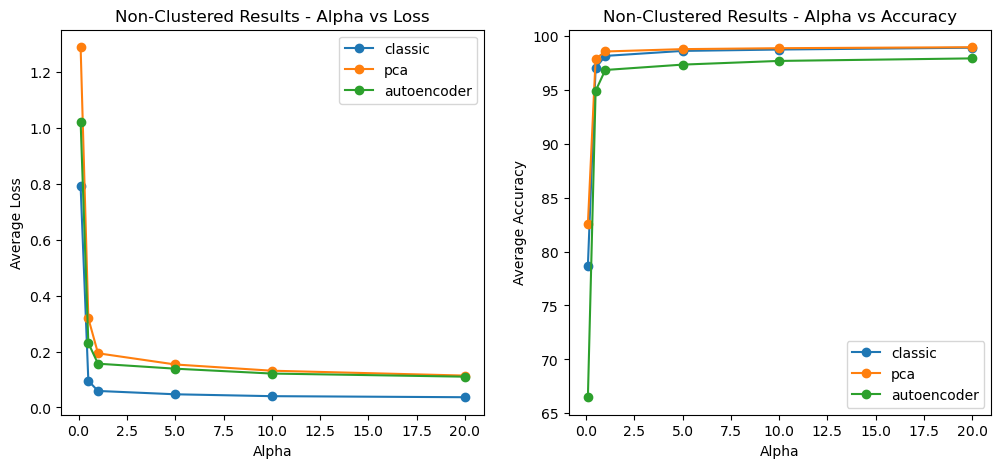


Clustered Results:
classic:
  Average Loss: {0.1: 0.18146381282806395, 0.5: 0.0717859203338623, 1: 0.051739701414108275, 5: 0.044363854598999025, 10: 0.038382955646514894, 20: 0.035685123014450065}
  Average Accuracy: {0.1: 94.68, 0.5: 97.64250000000001, 1: 98.37, 5: 98.62249999999999, 10: 98.83, 20: 98.915}
pca:
  Average Loss: {0.1: 0.5221160652160645, 0.5: 0.2365109519958496, 1: 0.17419830474853515, 5: 0.14556291847229005, 10: 0.1243785566329956, 20: 0.11292763500213623}
  Average Accuracy: {0.1: 96.2225, 0.5: 98.235, 1: 98.695, 5: 98.7475, 10: 98.9075, 20: 98.89}
autoencoder:
  Average Loss: {0.1: 0.40499098587036136, 0.5: 0.18346645030975342, 1: 0.14358580932617188, 5: 0.1262544885635376, 10: 0.11706847553253175, 20: 0.10840844540596009}
  Average Accuracy: {0.1: 90.0975, 0.5: 96.235, 1: 97.125, 5: 97.53, 10: 97.75999999999999, 20: 97.9425}


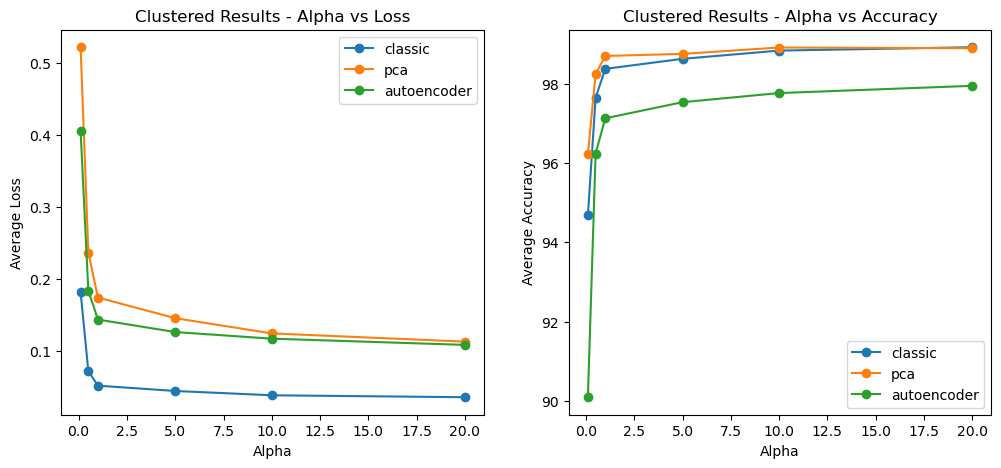

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    
    plt.savefig(filename)
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
